In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from construct import *
import scipy.signal

import sys
sys.path.append('../Tianwen/') # to import ccsds
import ccsds

import struct
import collections
import pathlib

In [2]:
CE5_AOSInsertZone = Struct(
    'unknown1' / Hex(Int8ub),
    'unknown2' / Int8ub,
    'unknown3' / Hex(Int8ub),
    'unknown4' / Hex(Int8ub),
    'timestamp' / Int32ul, # in units of 1s, epoch 2012-08-01 UTC
)

CE5_AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'insert_zone' / CE5_AOSInsertZone,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / GreedyBytes
)

def get_packet(p):
    return p[0] if type(p) is tuple else p

def packets_asarray(packets):
    return np.array([np.frombuffer(get_packet(p)[ccsds.SpacePacketPrimaryHeader.sizeof():], 'uint8')
                     for p in packets])

def plot_apids(apids, sc, vc):
    for apid in sorted(apids.keys()):
        plt.figure(figsize = (16,16), facecolor = 'w')
        ps = packets_asarray(apids[apid])
        plt.imshow(ps, aspect = ps.shape[1]/ps.shape[0])
        plt.title(f"Chang'e 5 Spacecraft {sc} APID {apid} Virtual channel {vc}")

def get_timestamps(x):
    return np.datetime64('2012-08-01') + np.timedelta64(1,'s')*np.array(x)
        
def get_packet_timestamps(packets):
    return get_timestamps([p[1] for p in packets])

In this notebook we analyzed the frames decoded off the low datarate (PCM/PM/PSK 2048baud with 65536Hz subcarrier) signal of the Chang'e 5 lander+ascender combo at 8463.7 MHz transmitted from the lunar surface on 2020-12-02.

In [3]:
def load_frames(path):
    frame_size = 220
    frames = np.fromfile(path, dtype = 'uint8')
    return frames[:frames.size//frame_size*frame_size].reshape((-1, frame_size))

frames = load_frames('Bochum_2020-12-02_8463/SDRSharp_20201202_060001Z_8463752190Hz_IQ_2M5_dec8_CE5_frames.u8')

## AOS frames

AOS frames come from spacecraft 91 and virtual channels 1.

In [4]:
aos = [CE5_AOSFrame.parse(f) for f in frames]

In [5]:
collections.Counter([a.primary_header.transfer_frame_version_number for a in aos])

Counter({1: 480})

In [6]:
collections.Counter([a.primary_header.spacecraft_id for a in aos
                    if a.primary_header.transfer_frame_version_number == 1])

Counter({91: 480})

In [7]:
collections.Counter([a.primary_header.virtual_channel_id for a in aos
                    if a.primary_header.transfer_frame_version_number == 1])

Counter({1: 480})

In [8]:
[a.primary_header for a in aos if a.primary_header.virtual_channel_id == 1][:10]

[Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=386762, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=386763, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=386764, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=386765, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=91, virtual_channel_id=1, virtual_channel_frame_count=386766, replay_flag=False, vc_frame_count_usage_

In [9]:
fc = np.array([a.primary_header.virtual_channel_frame_count for a in aos])
t = get_timestamps([a.insert_zone.timestamp for a in aos])

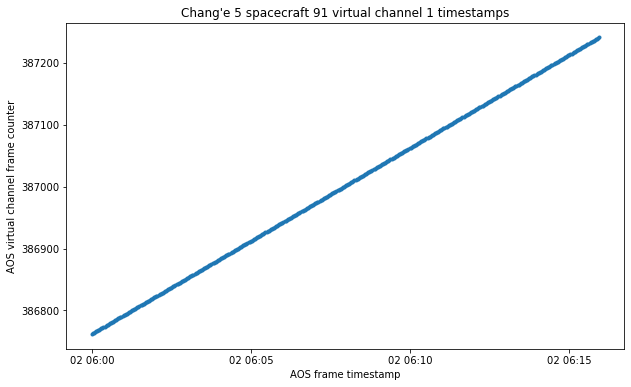

In [10]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(t, fc, '.')
plt.title("Chang'e 5 spacecraft 91 virtual channel 1 timestamps")
plt.xlabel('AOS frame timestamp')
plt.ylabel('AOS virtual channel frame counter');

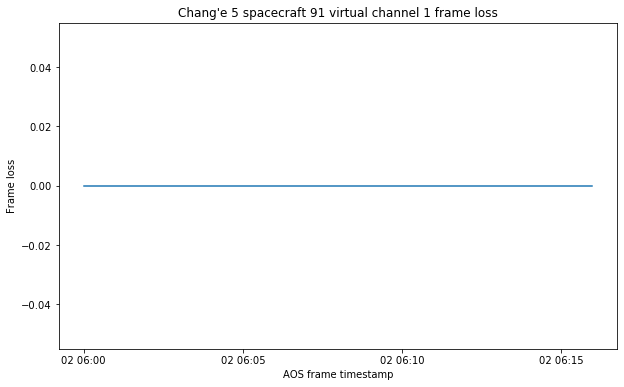

In [11]:
plt.figure(figsize = (10,6), facecolor = 'w')
plt.plot(t[1:], np.diff(fc)-1)
plt.title("Chang'e 5 spacecraft 91 virtual channel 1 frame loss")
plt.xlabel('AOS frame timestamp')
plt.ylabel('Frame loss');

In [12]:
vc1_packets = list(ccsds.extract_space_packets(aos, 91, 1, get_timestamps = True))

In [13]:
vc1_sp_headers = [ccsds.SpacePacketPrimaryHeader.parse(p[0]) for p in vc1_packets]

There are space packets in may APIDs. The contents of each APID are shown belown in plot form, but it's not easy to guess what any of the values mean.

In [14]:
vc1_apids = collections.Counter([p.APID for p in vc1_sp_headers])
vc1_apids

Counter({514: 240,
         526: 480,
         574: 179,
         793: 169,
         529: 170,
         530: 101,
         777: 157,
         779: 15,
         537: 171,
         515: 172,
         560: 183,
         517: 55,
         561: 179,
         531: 101,
         516: 55,
         566: 29,
         524: 101,
         778: 84,
         770: 56,
         512: 59,
         568: 55,
         776: 102,
         794: 29,
         521: 15,
         518: 55,
         520: 54,
         564: 55,
         804: 15,
         542: 15,
         538: 28,
         786: 28,
         803: 28,
         798: 15,
         772: 14,
         541: 14,
         797: 14})

In [15]:
vc1_by_apid = {apid : [p for h,p in zip(vc1_sp_headers, vc1_packets)
                           if h.APID == apid] for apid in vc1_apids}

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


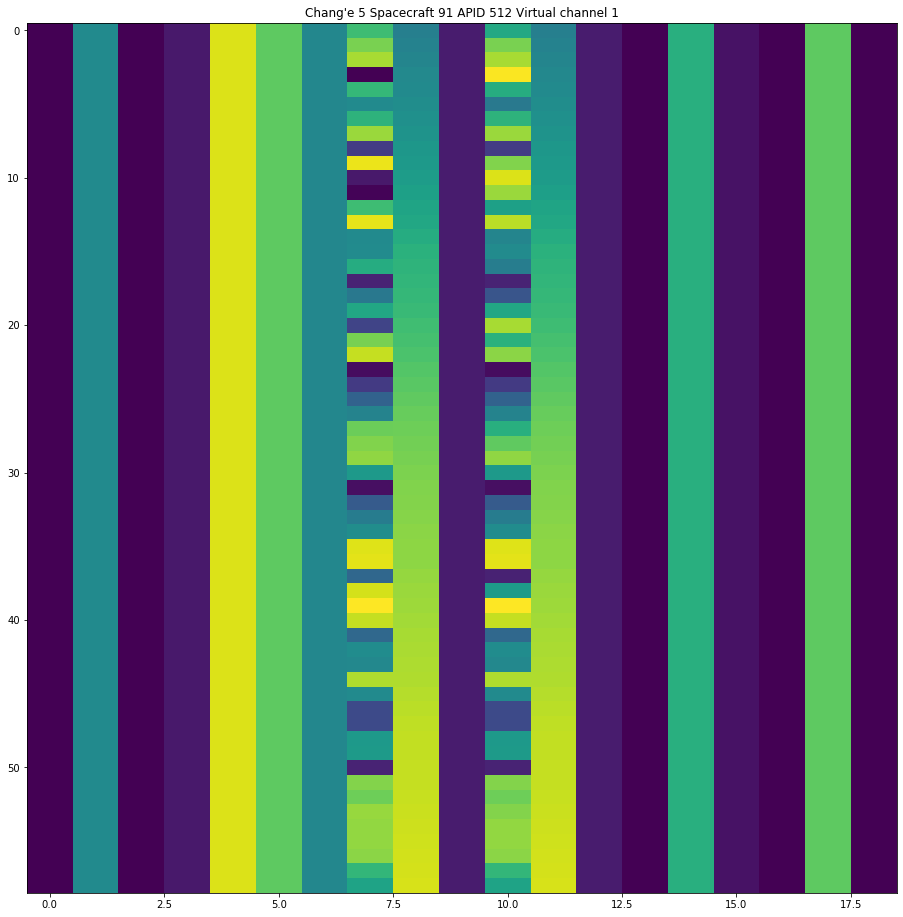

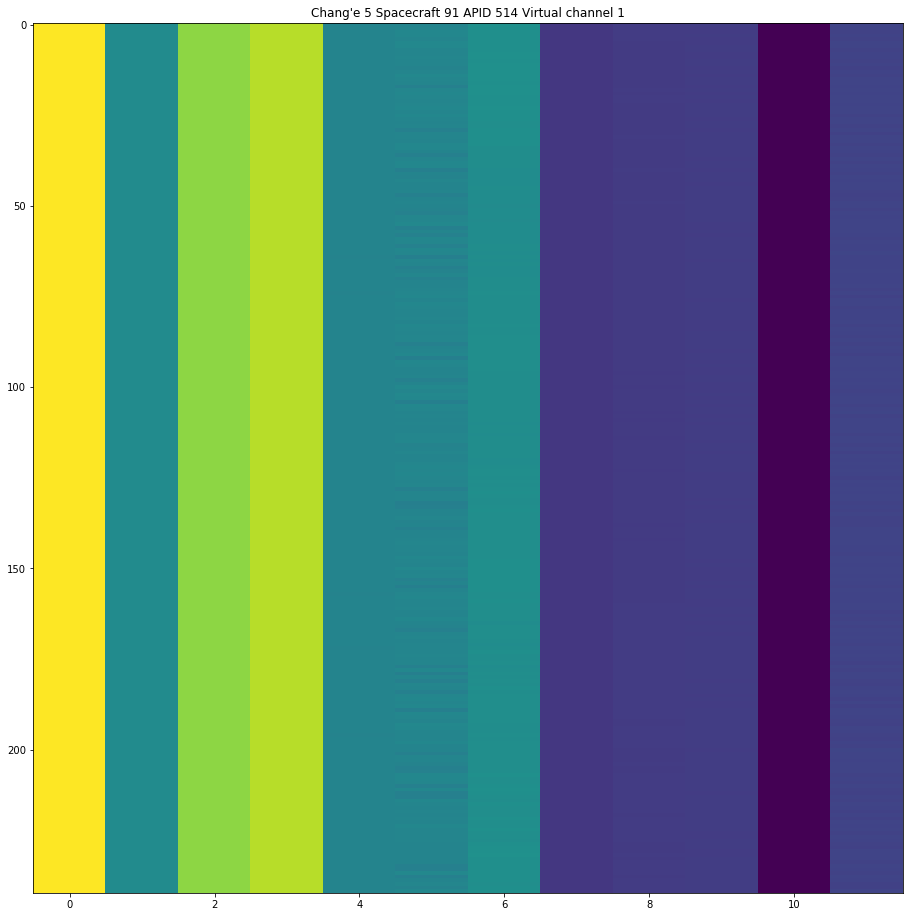

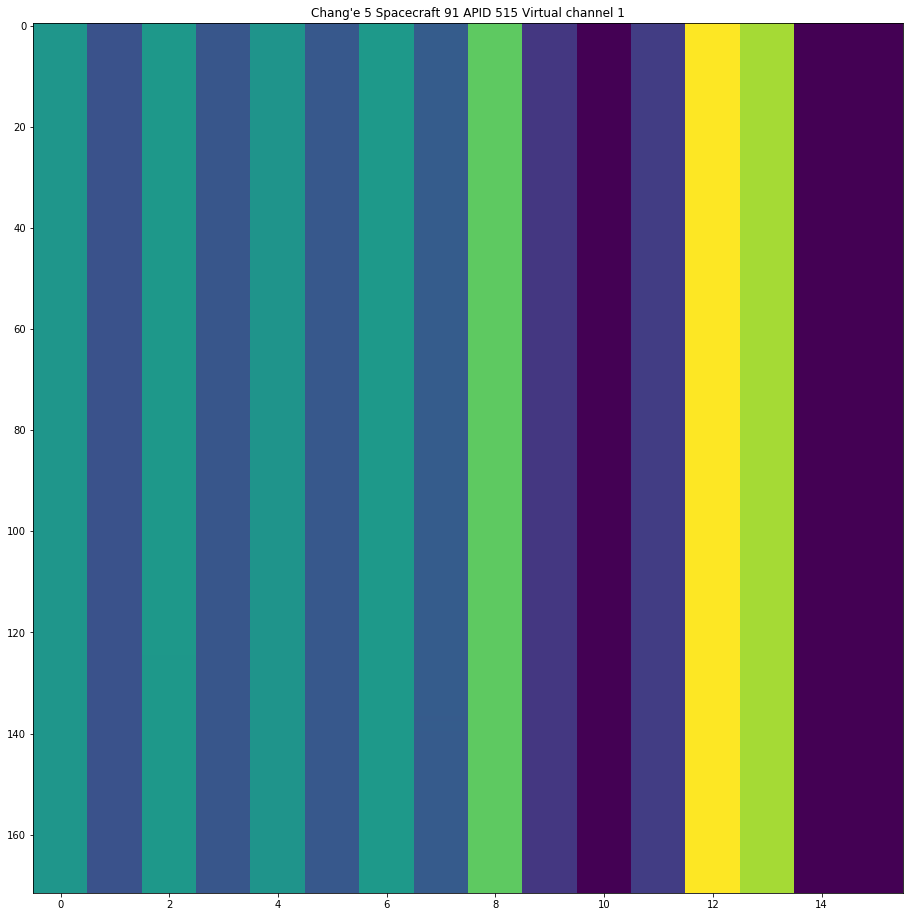

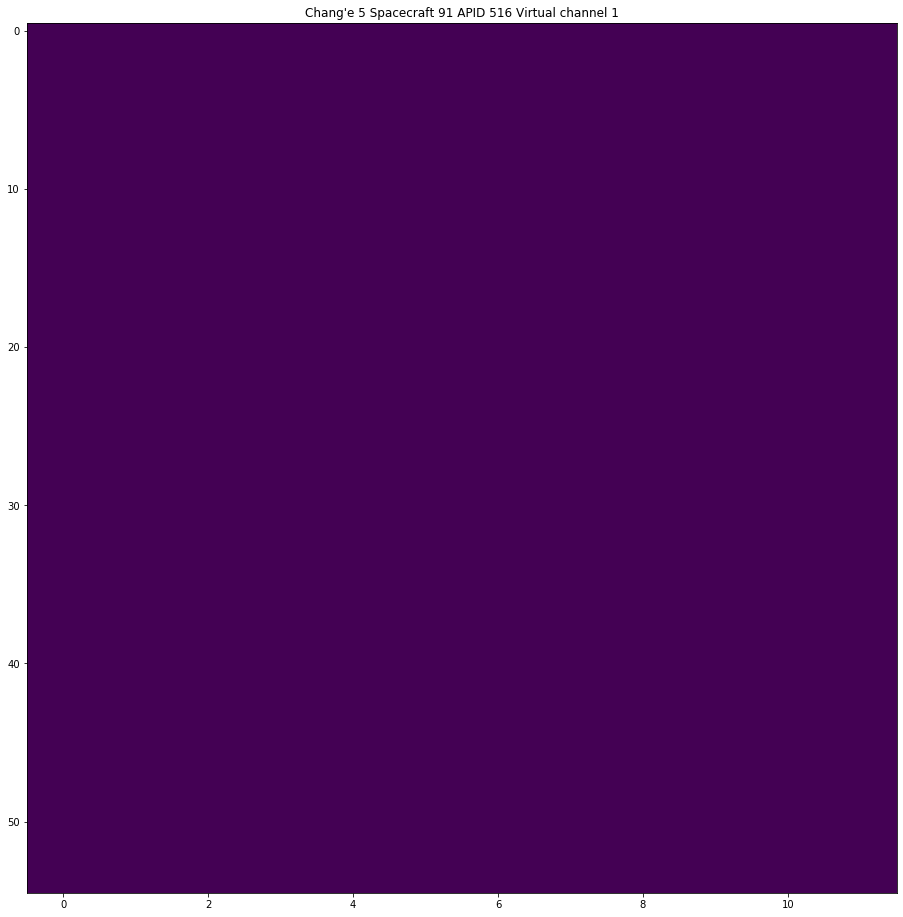

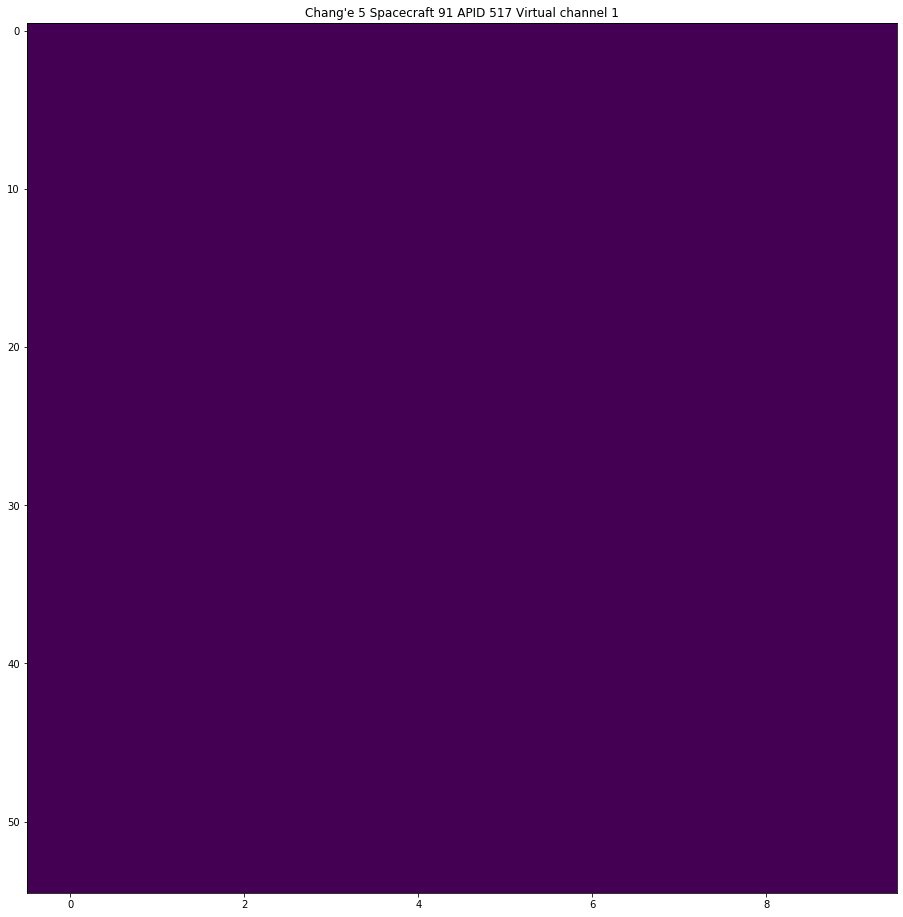

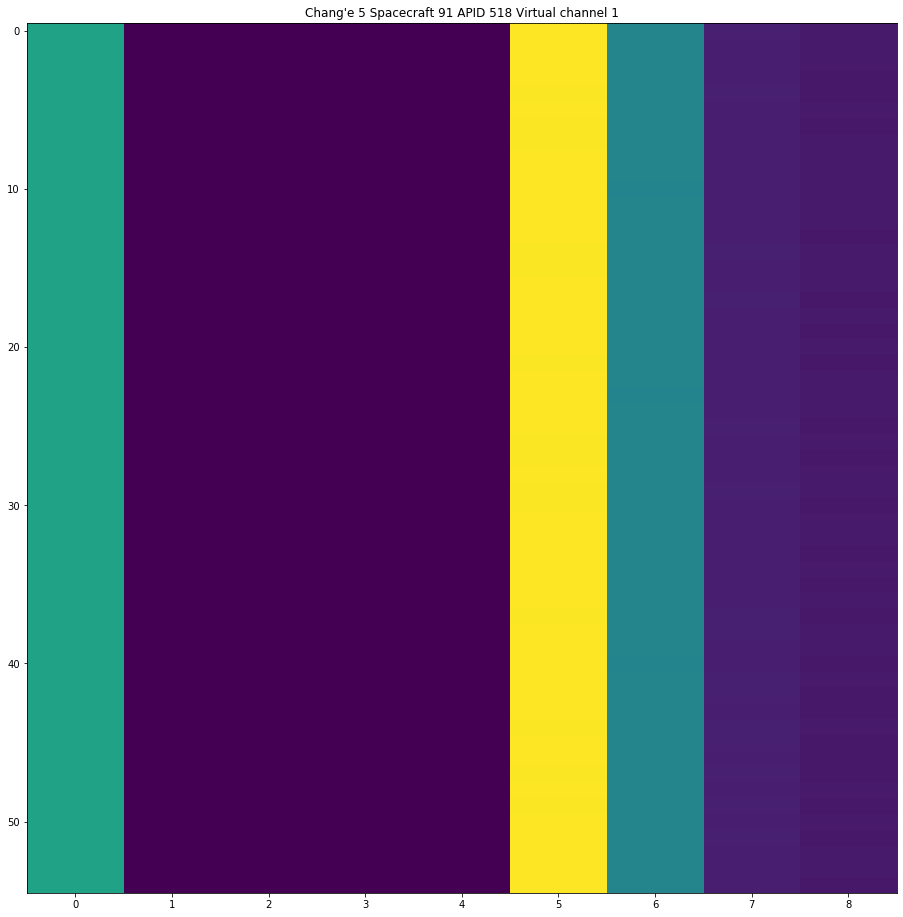

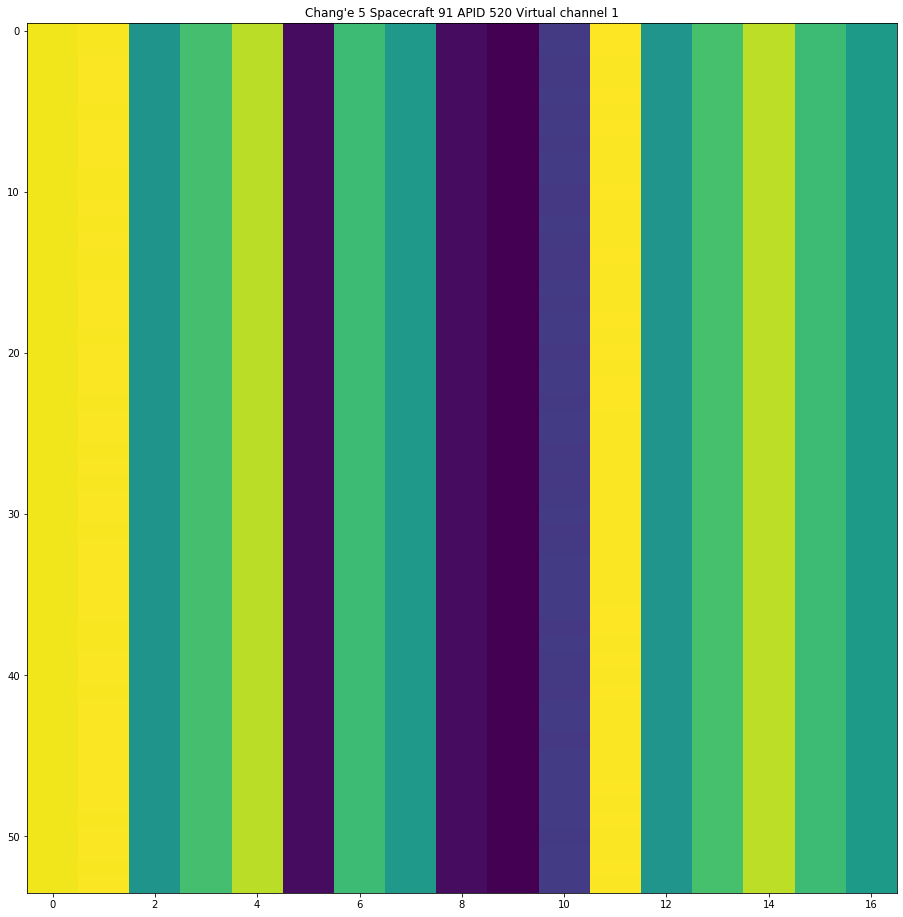

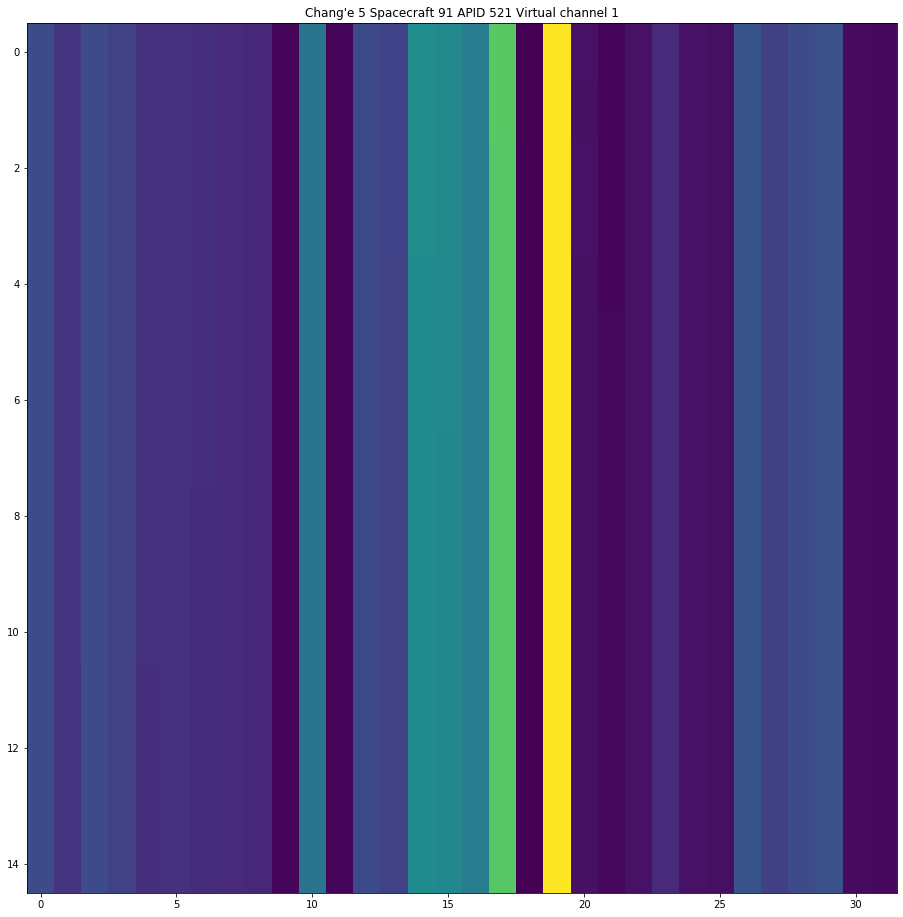

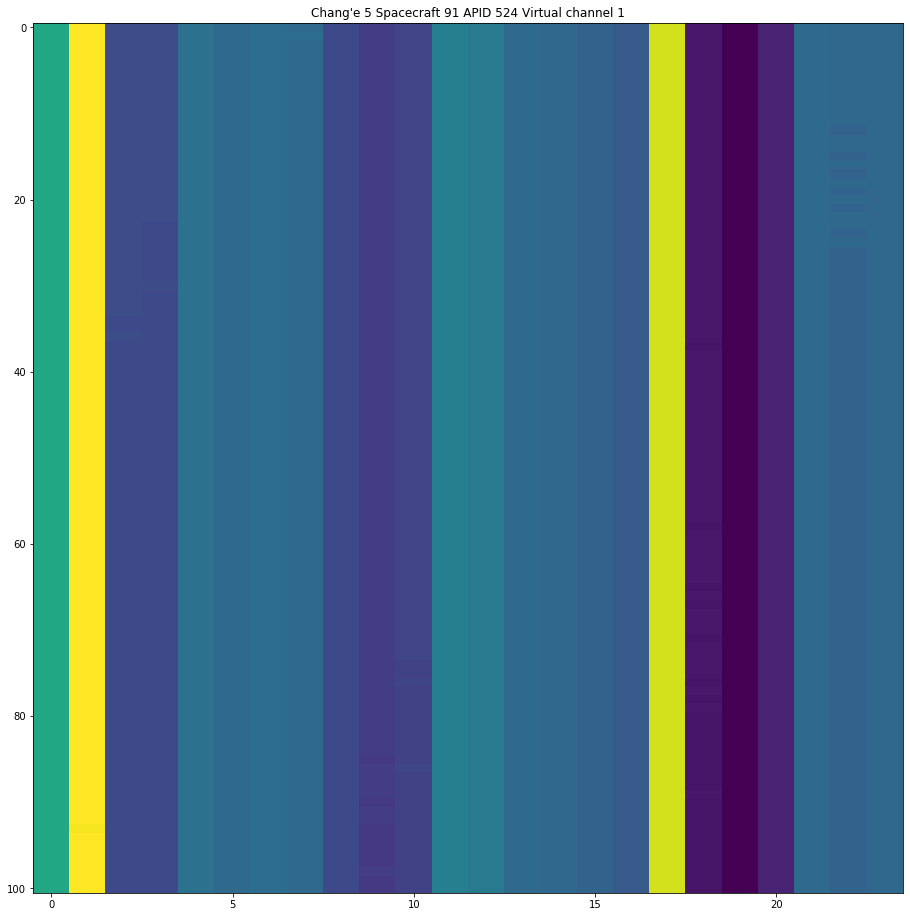

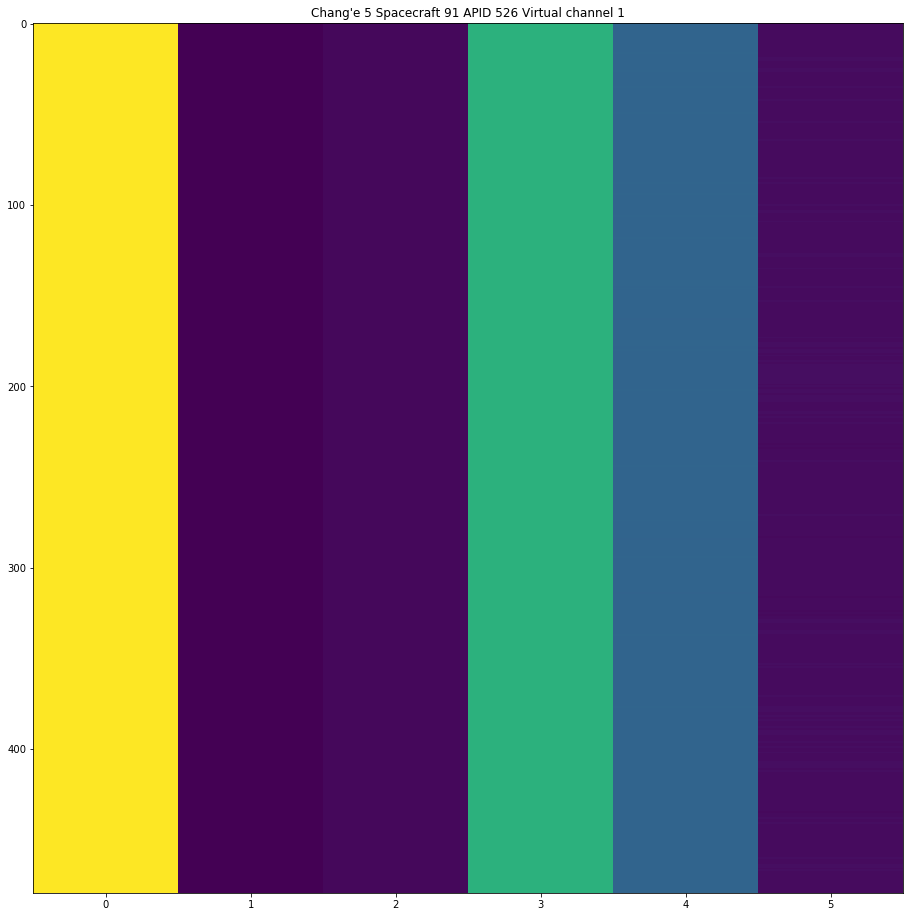

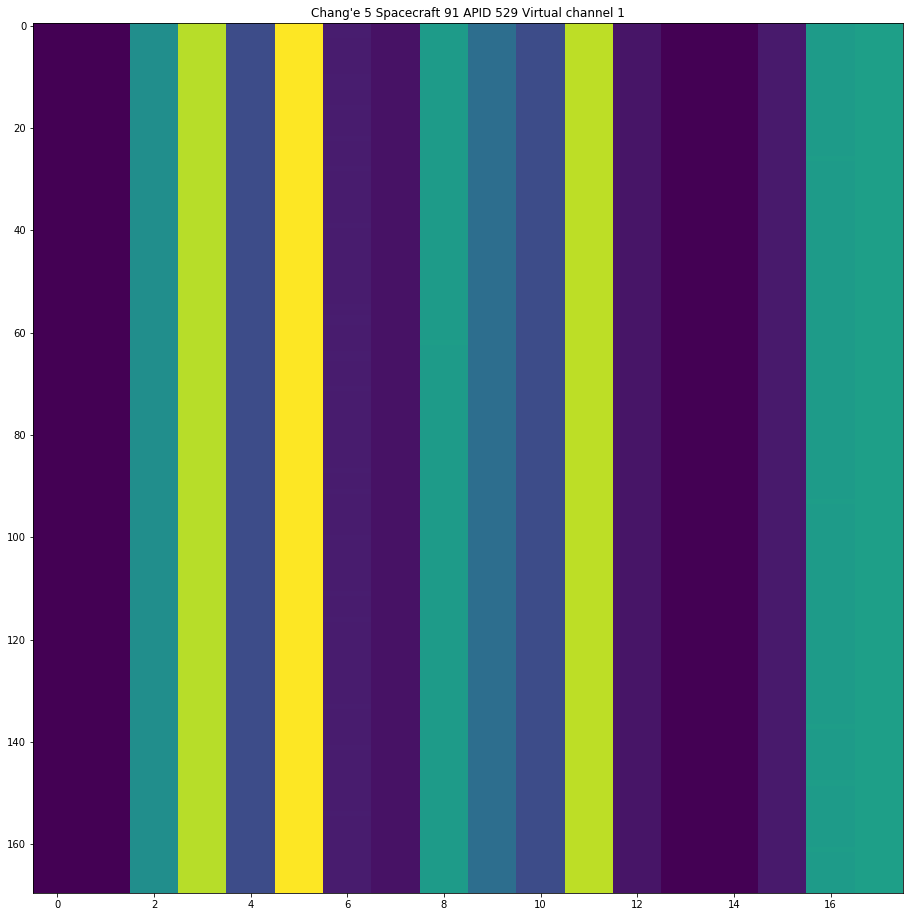

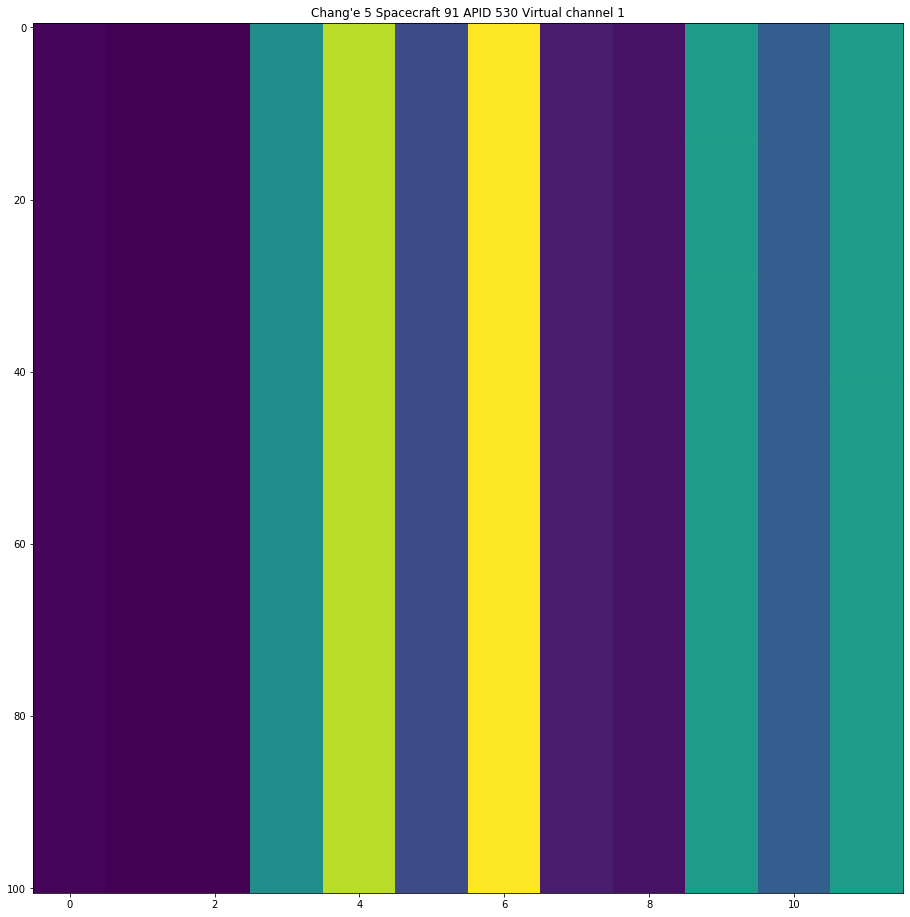

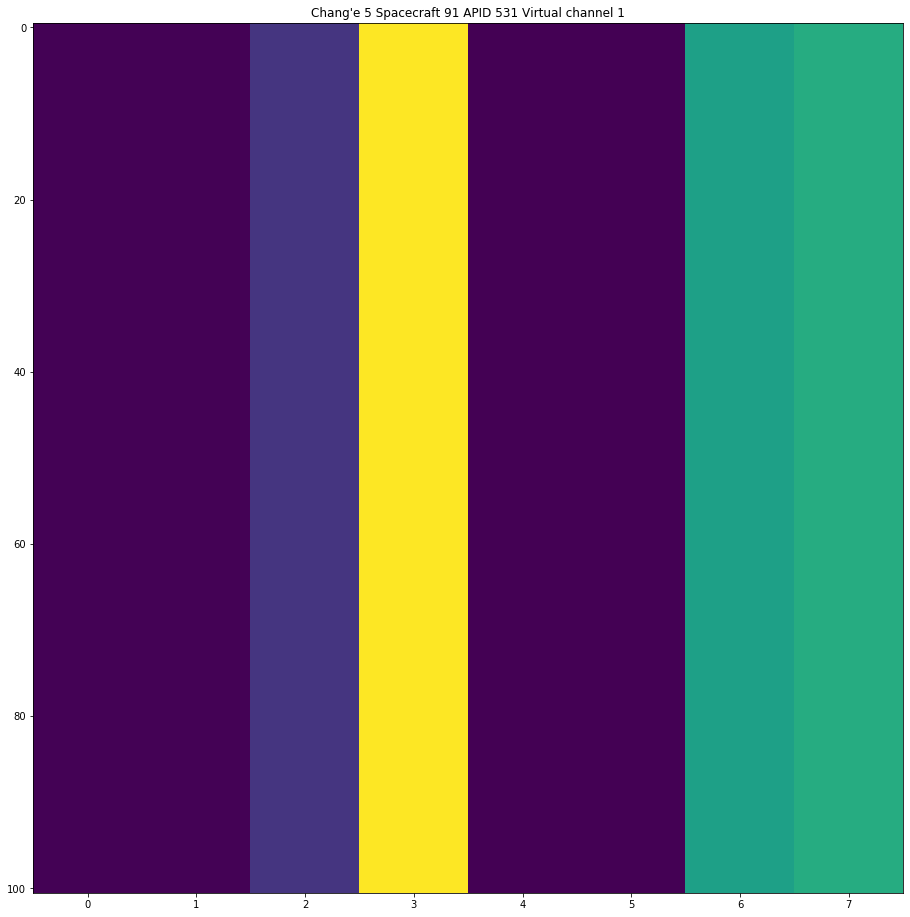

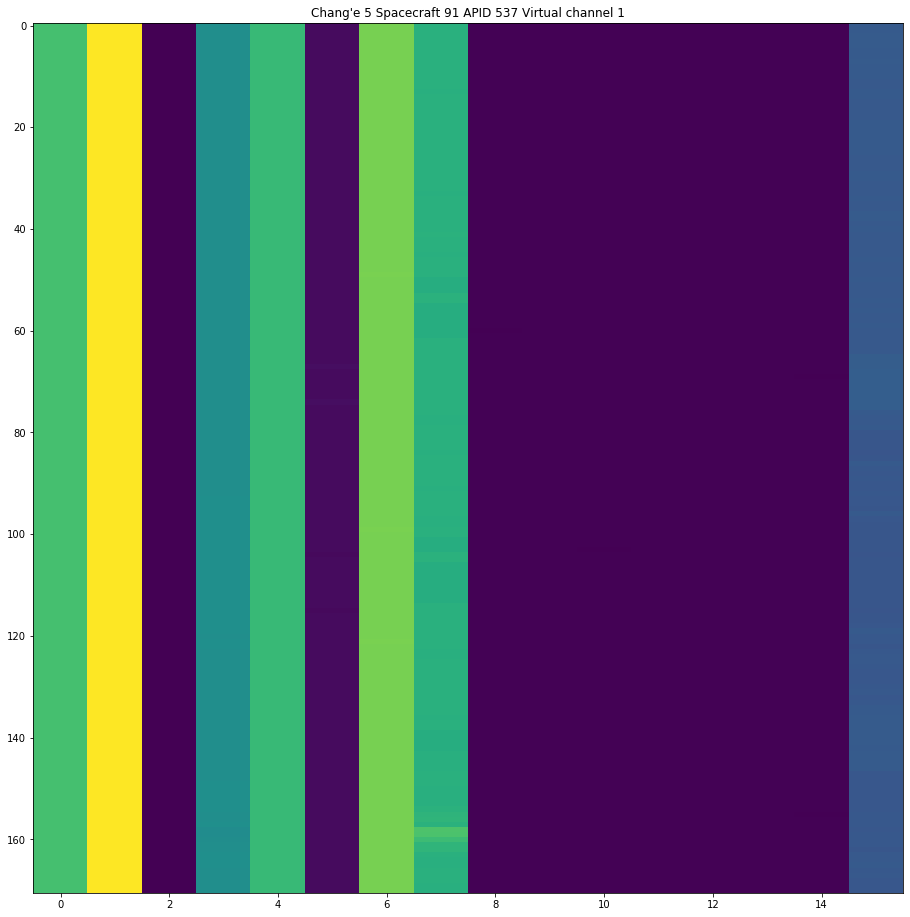

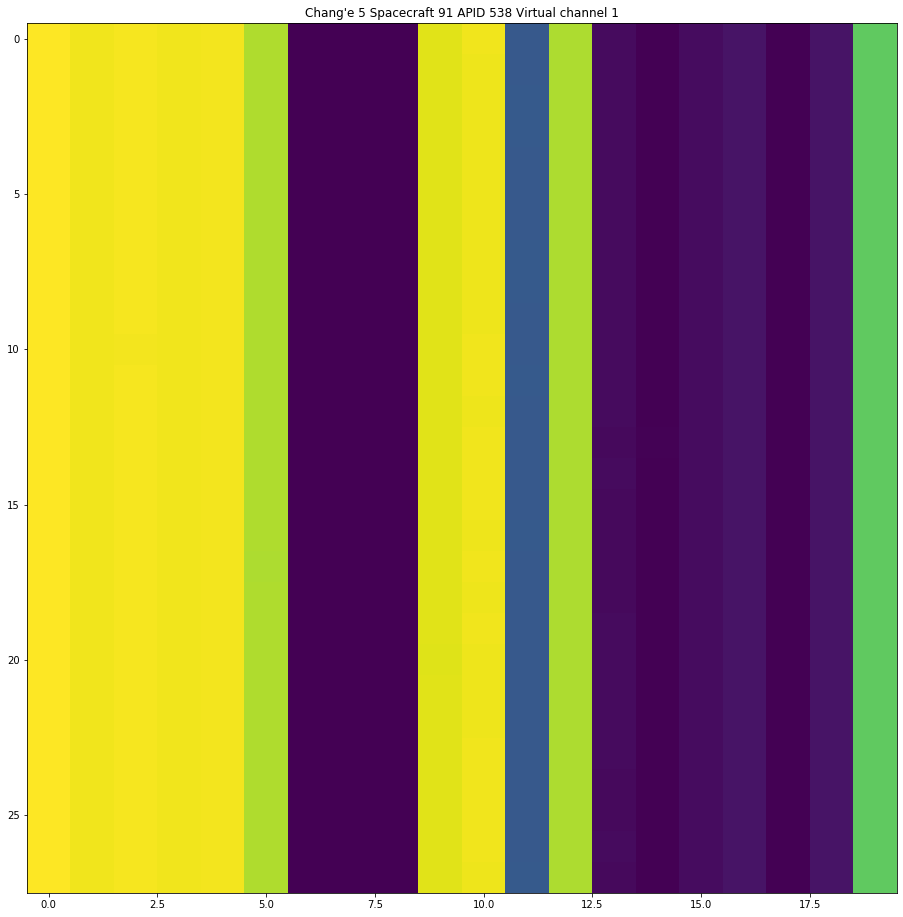

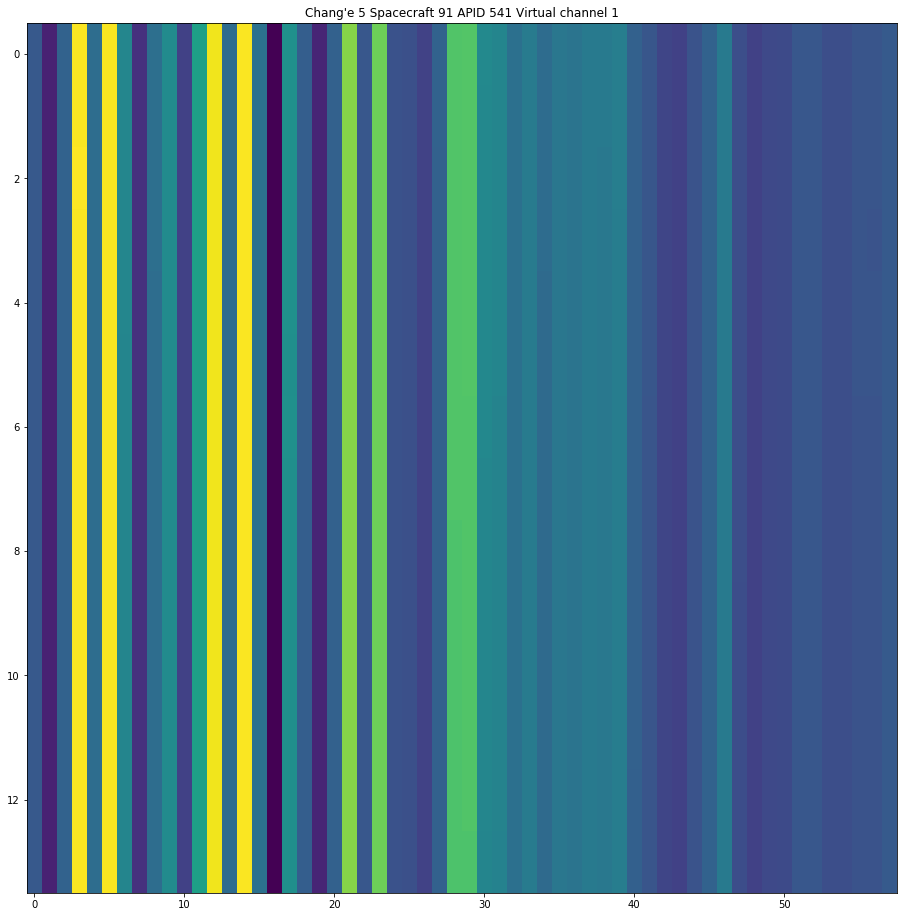

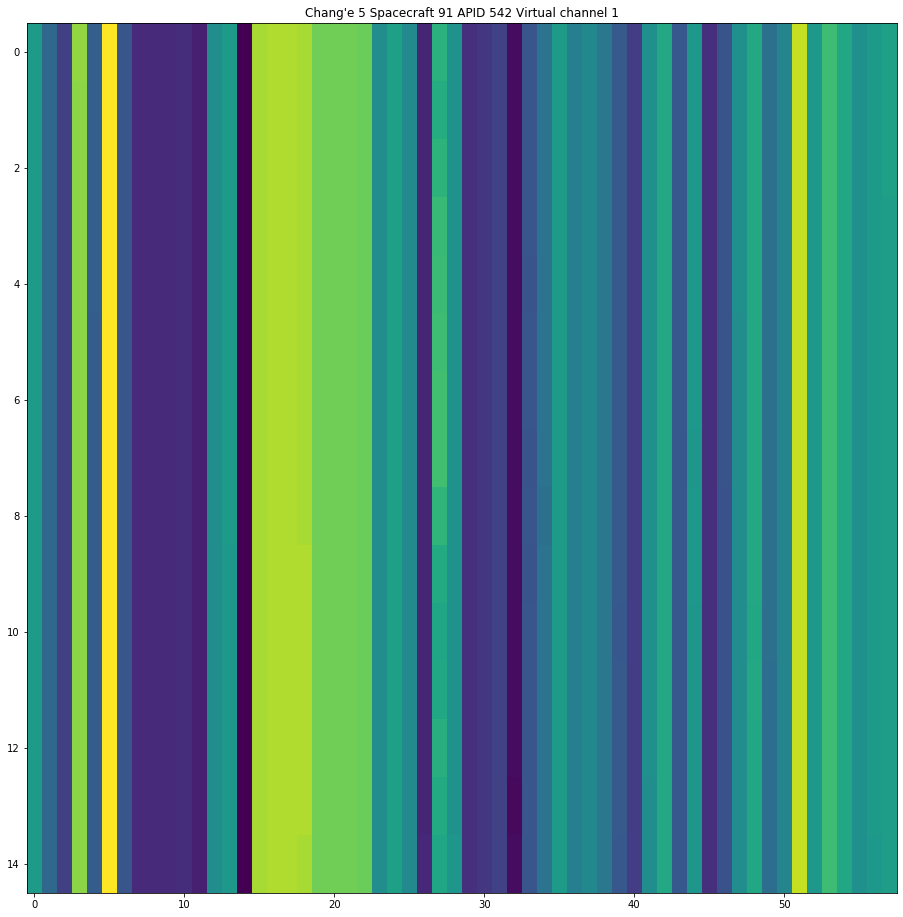

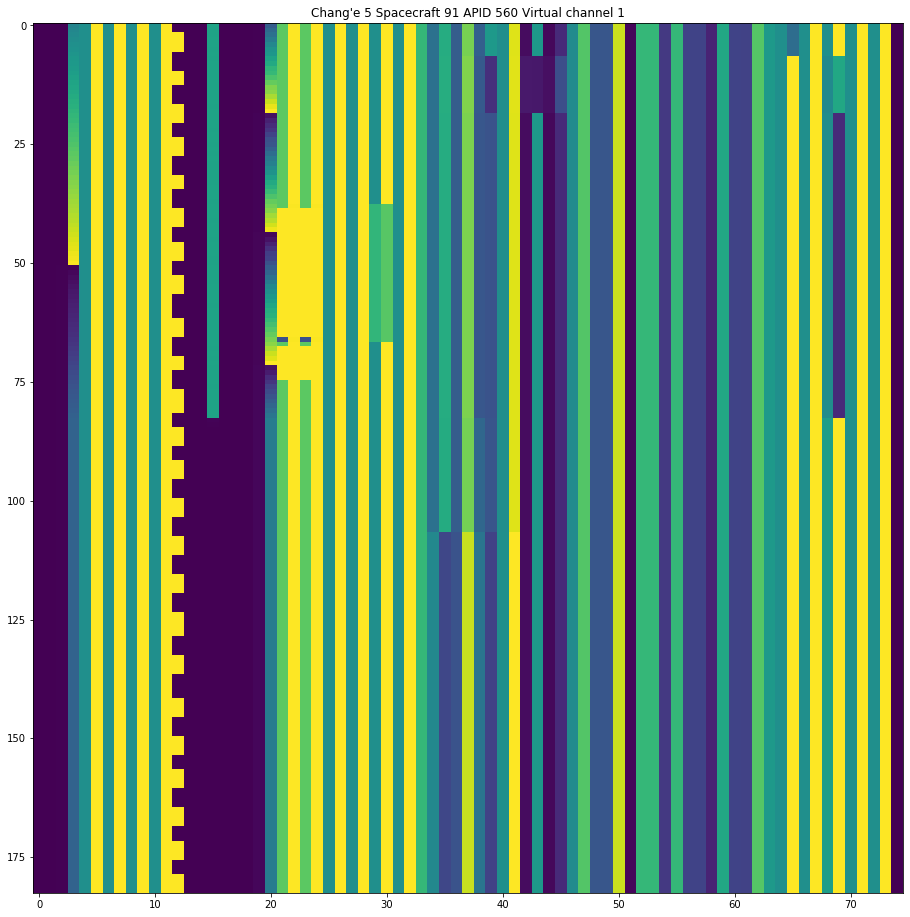

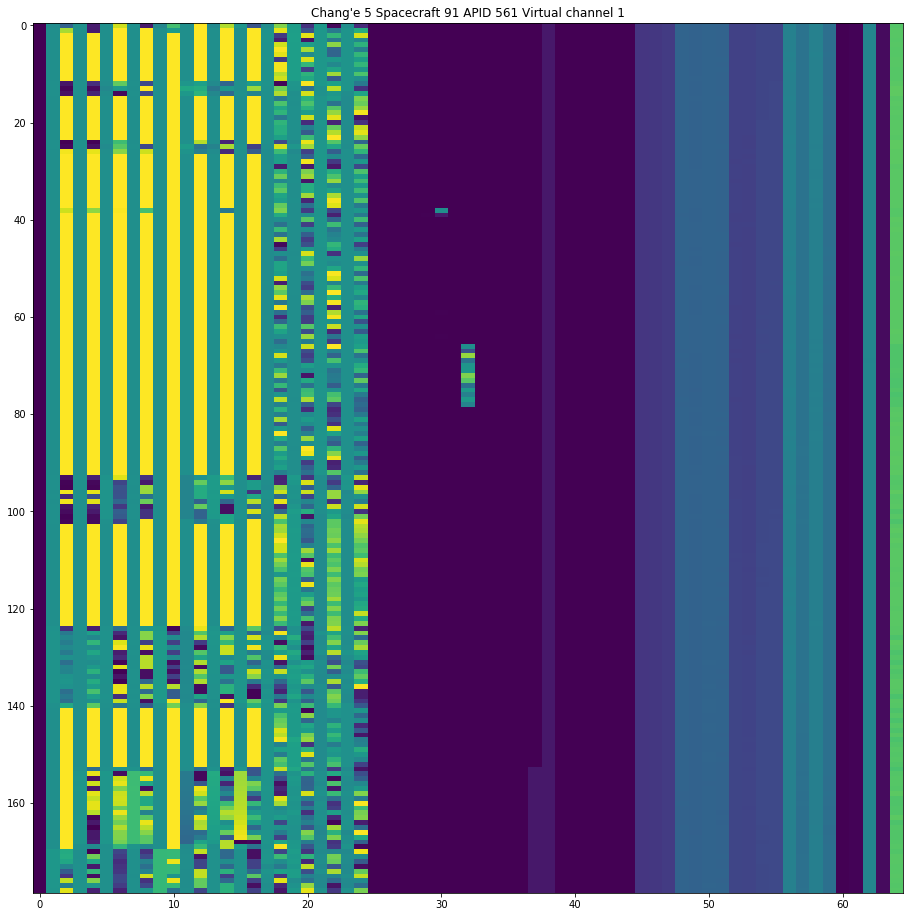

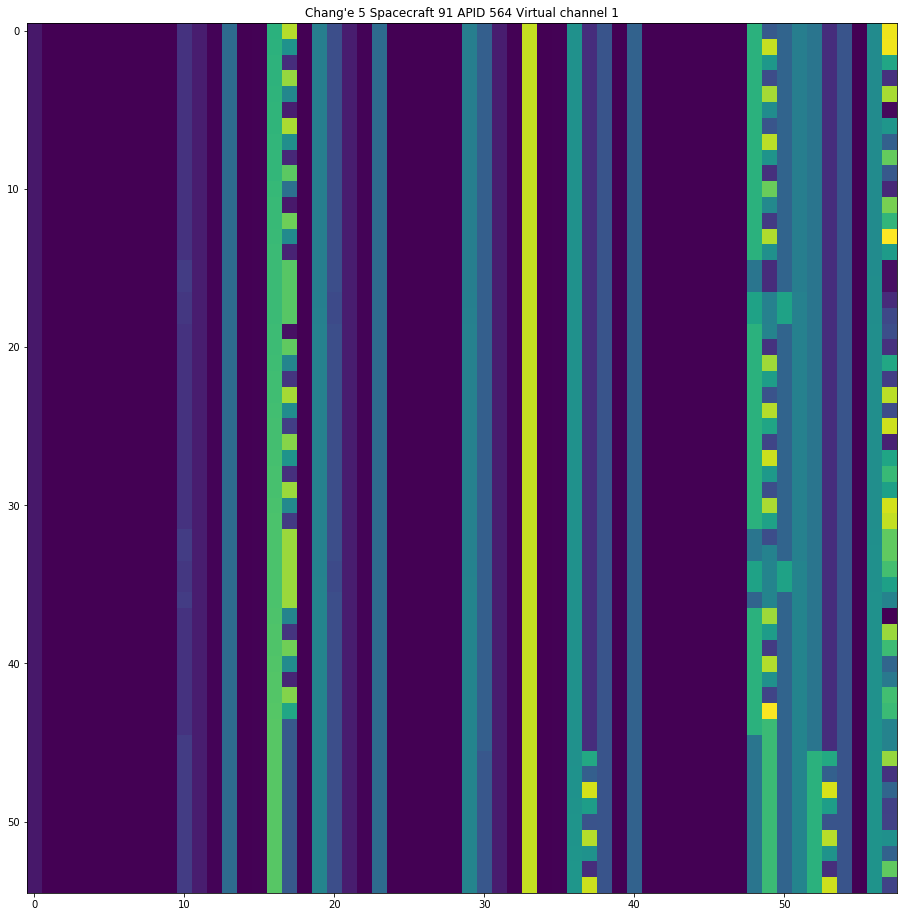

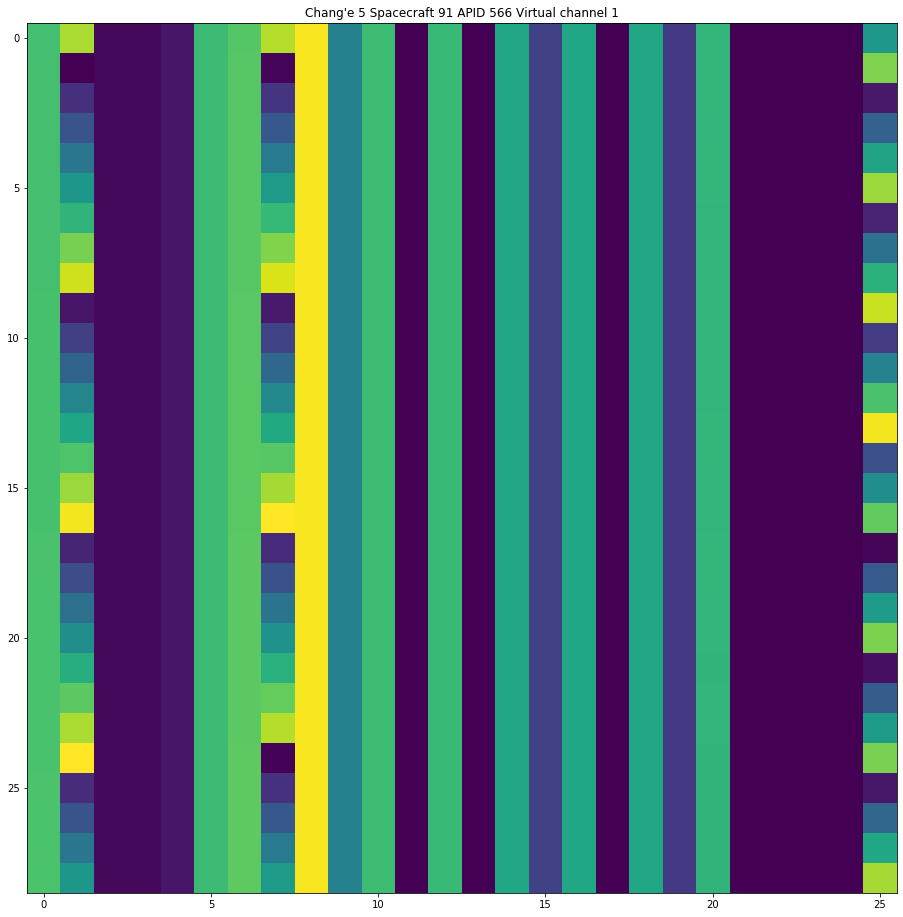

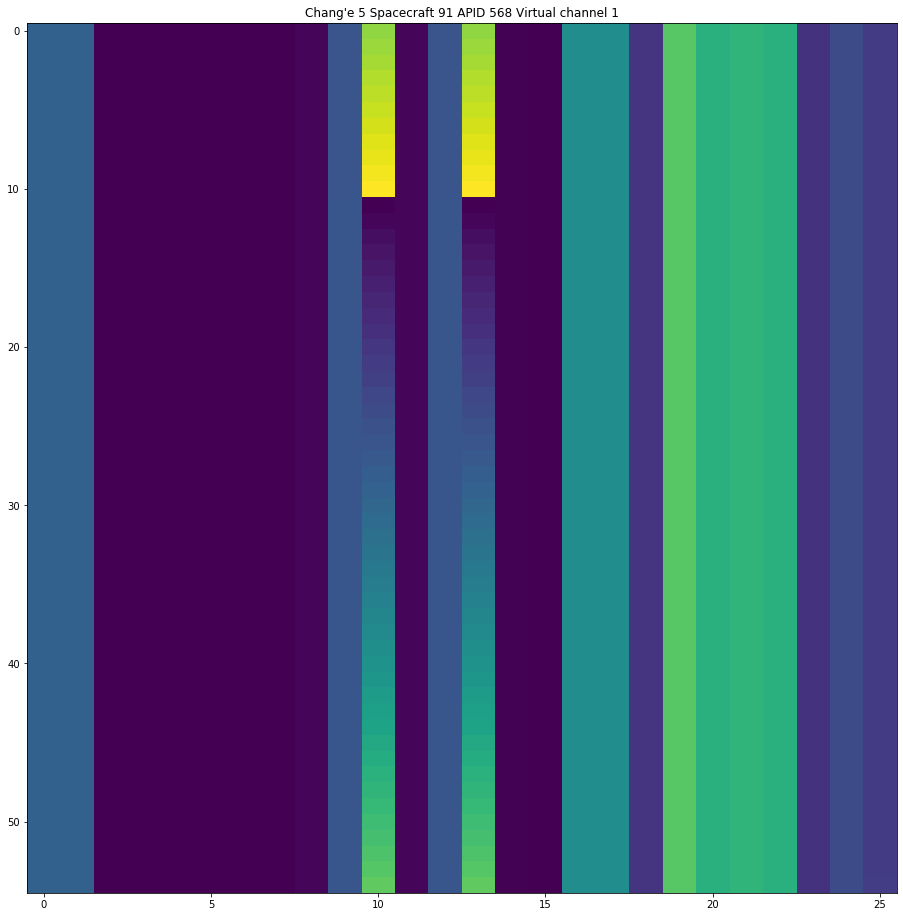

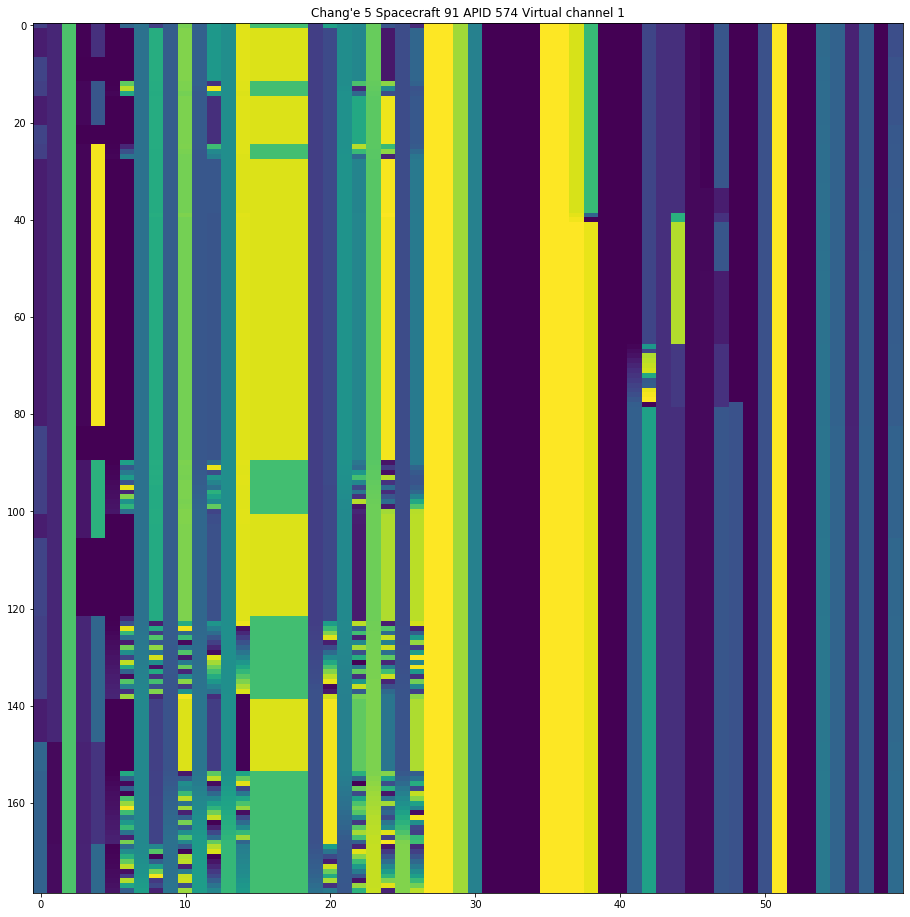

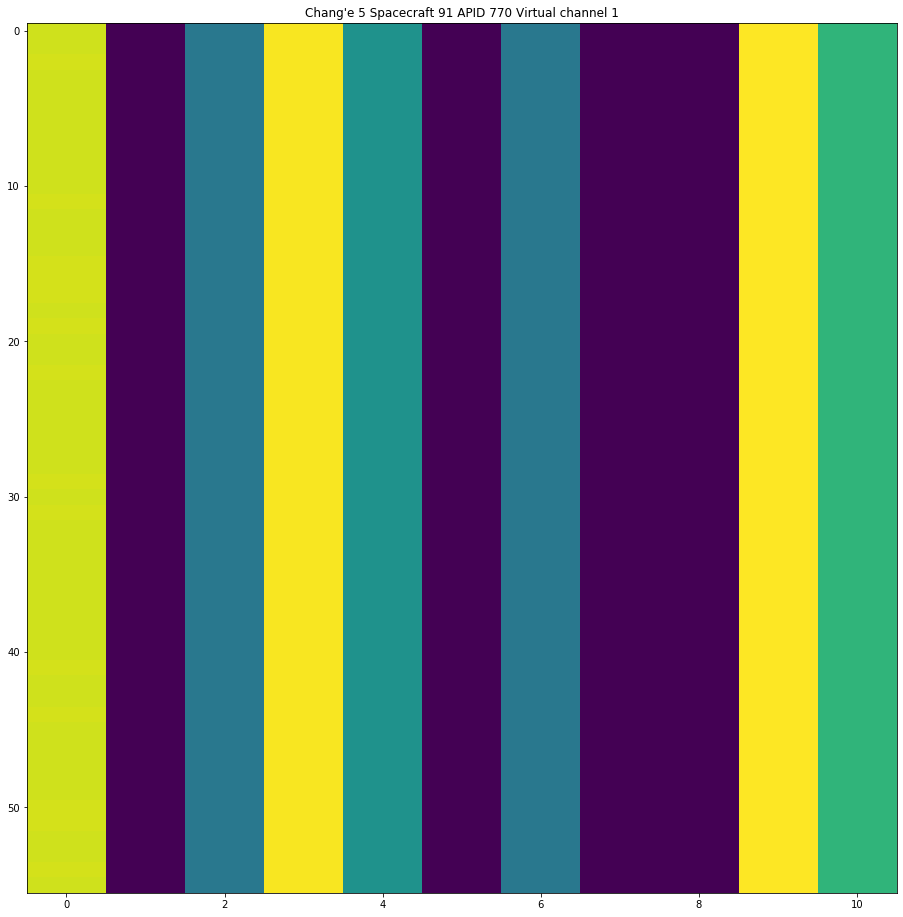

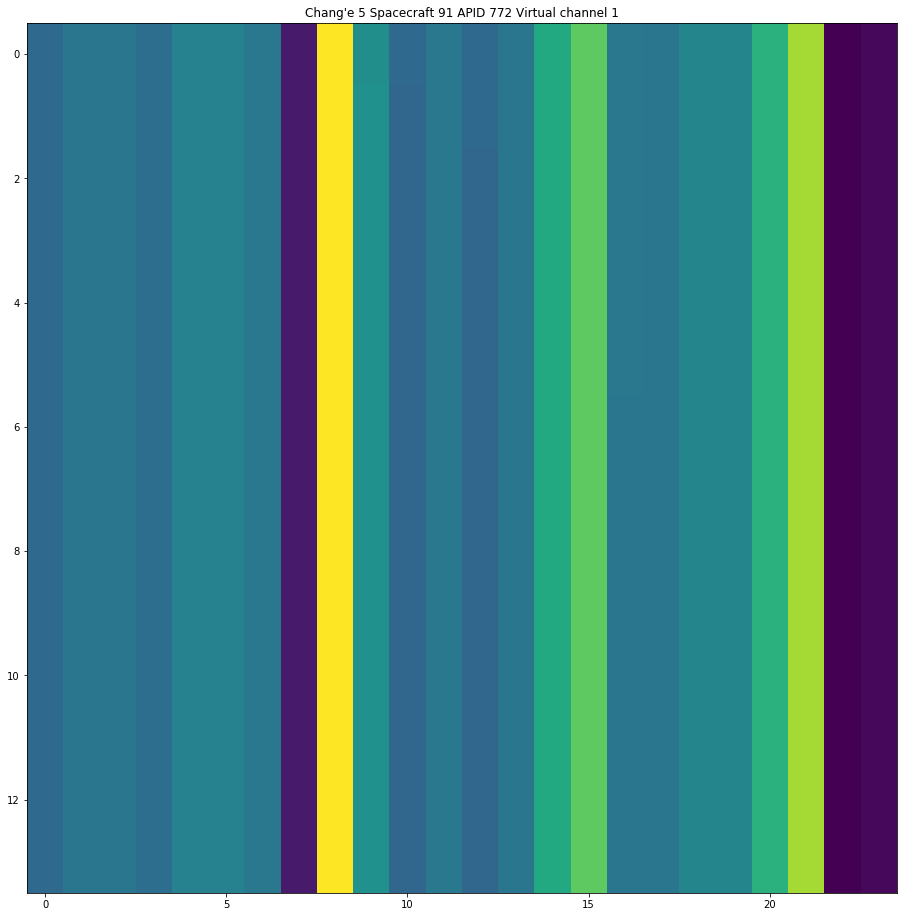

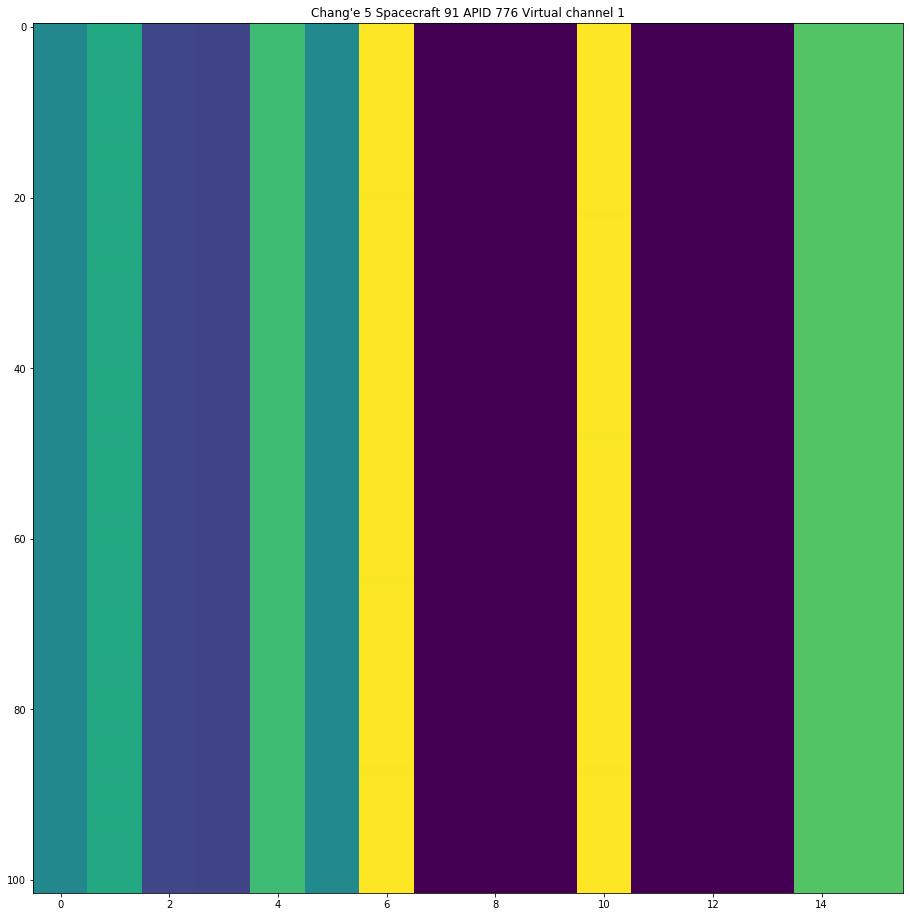

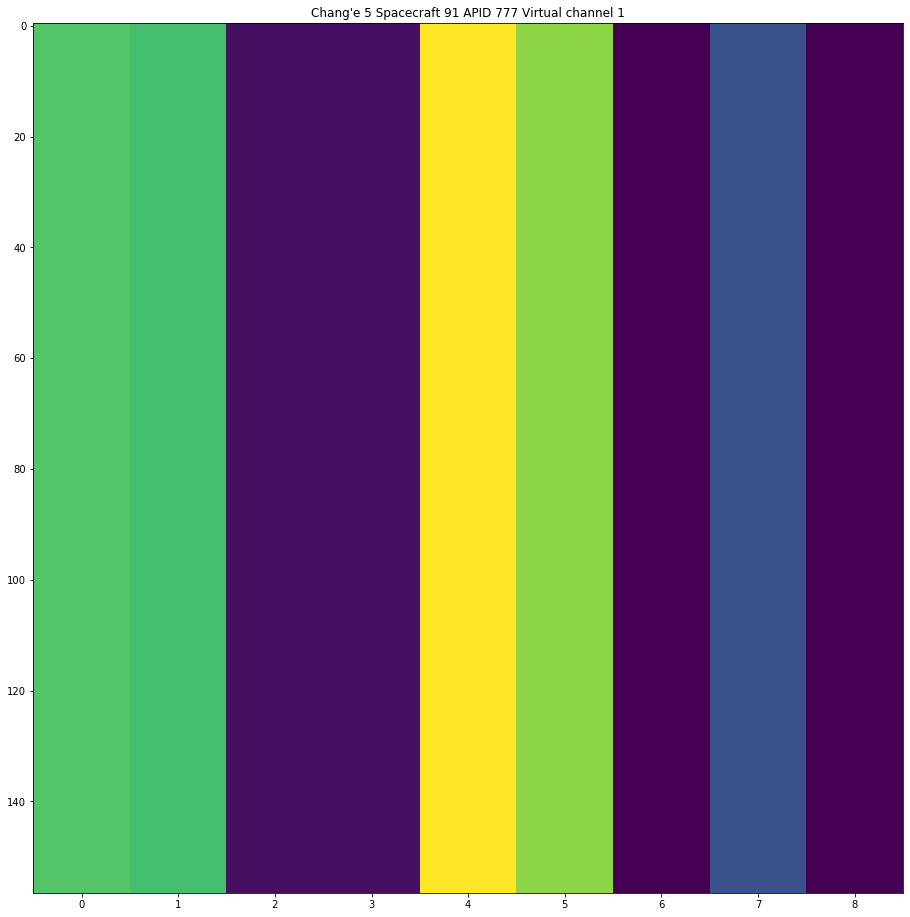

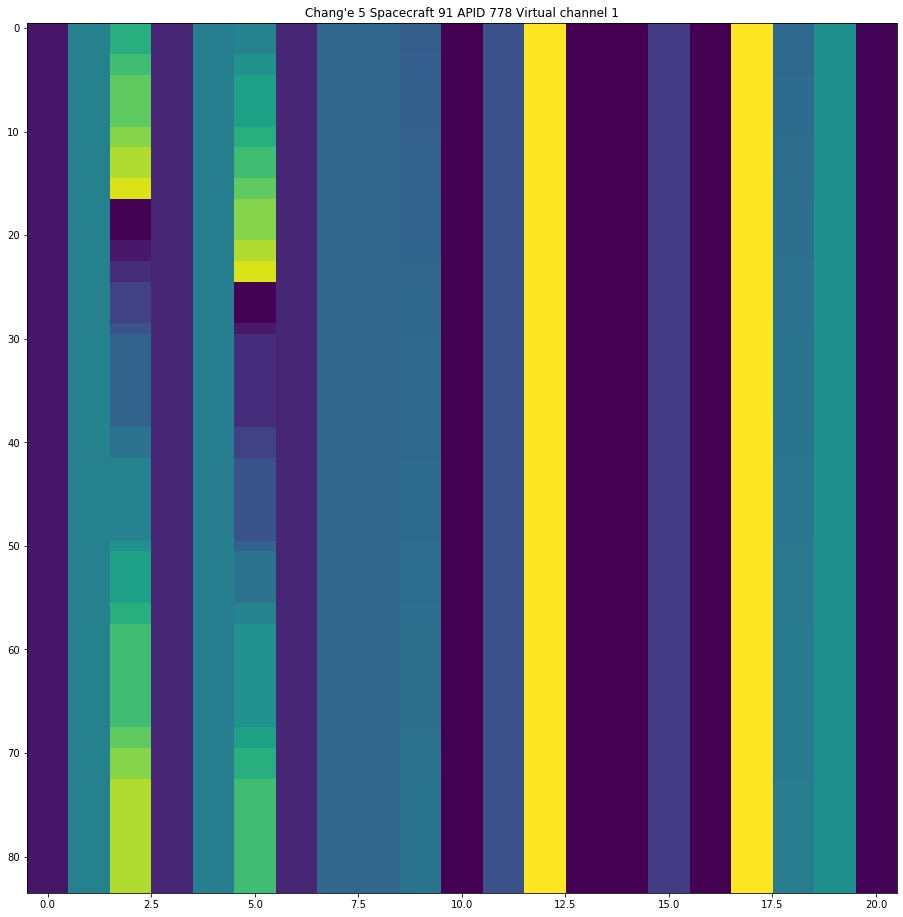

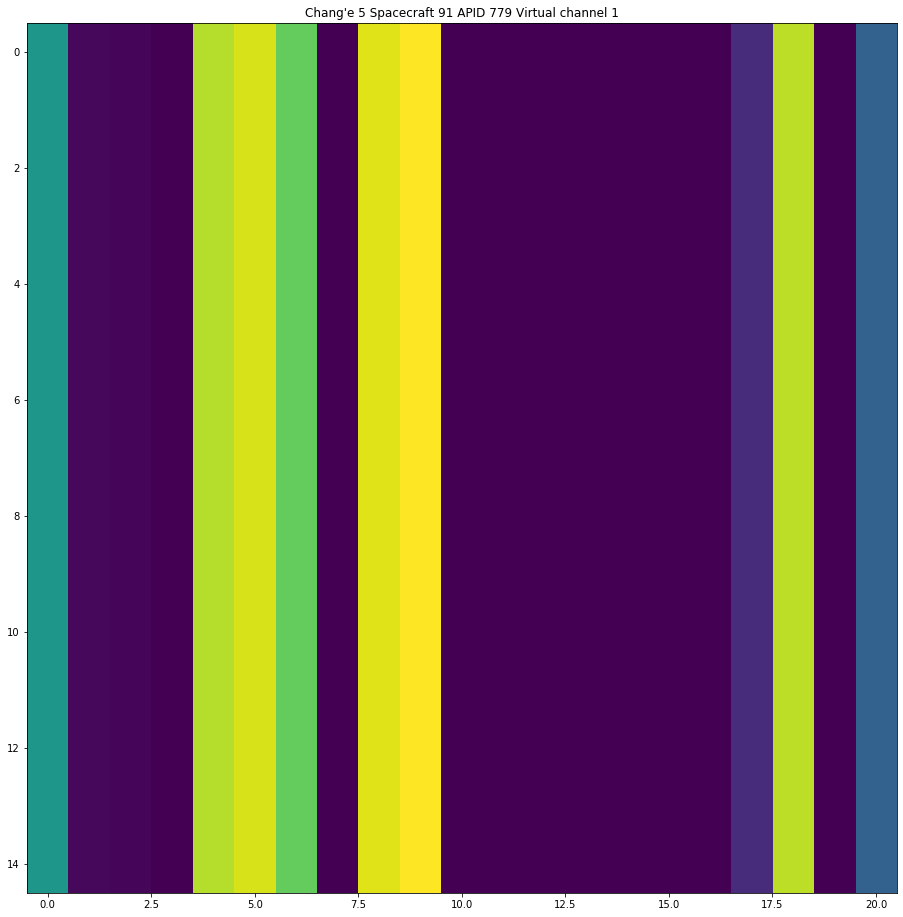

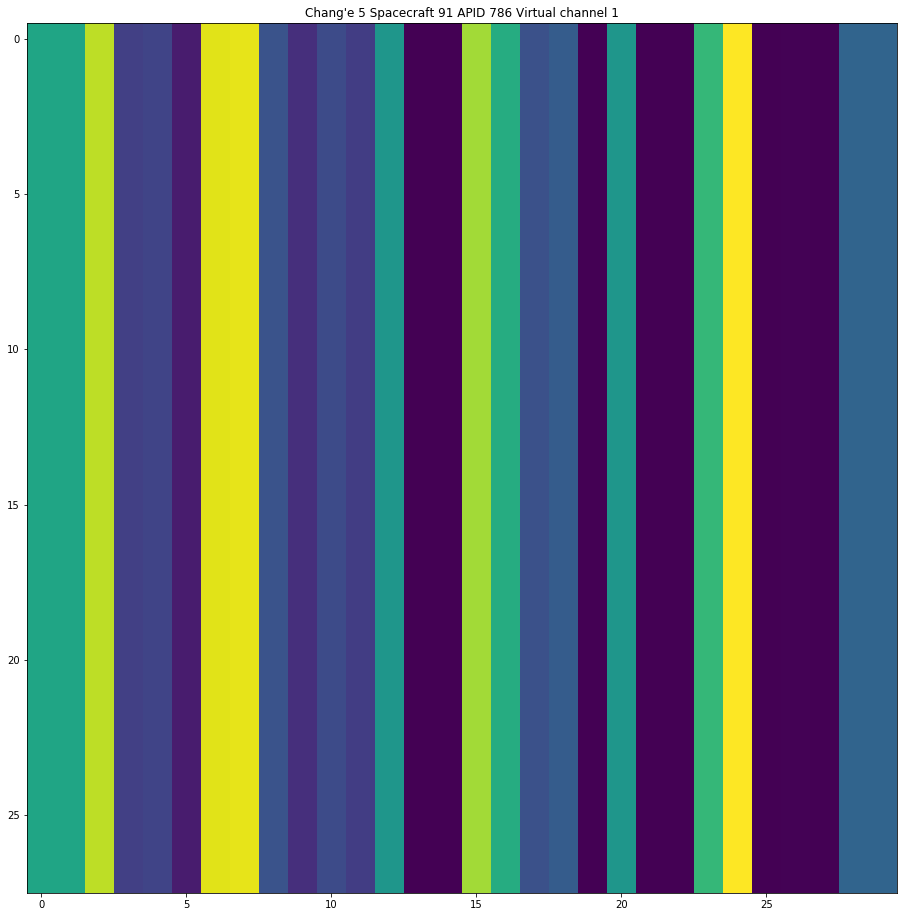

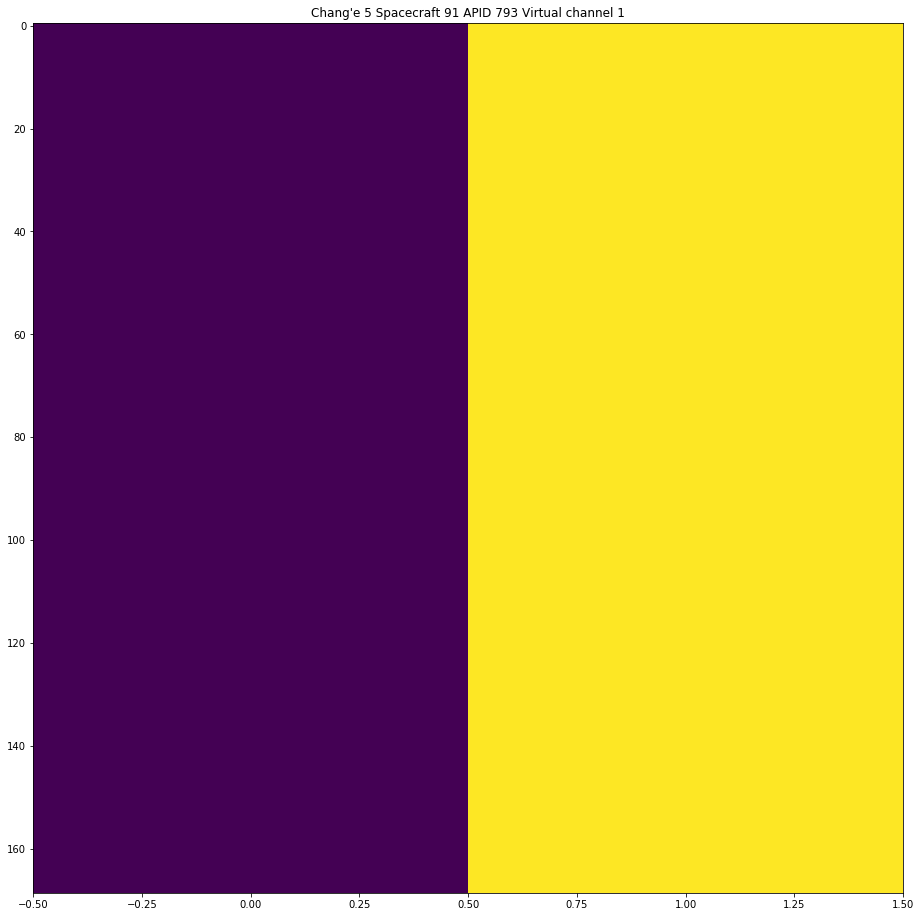

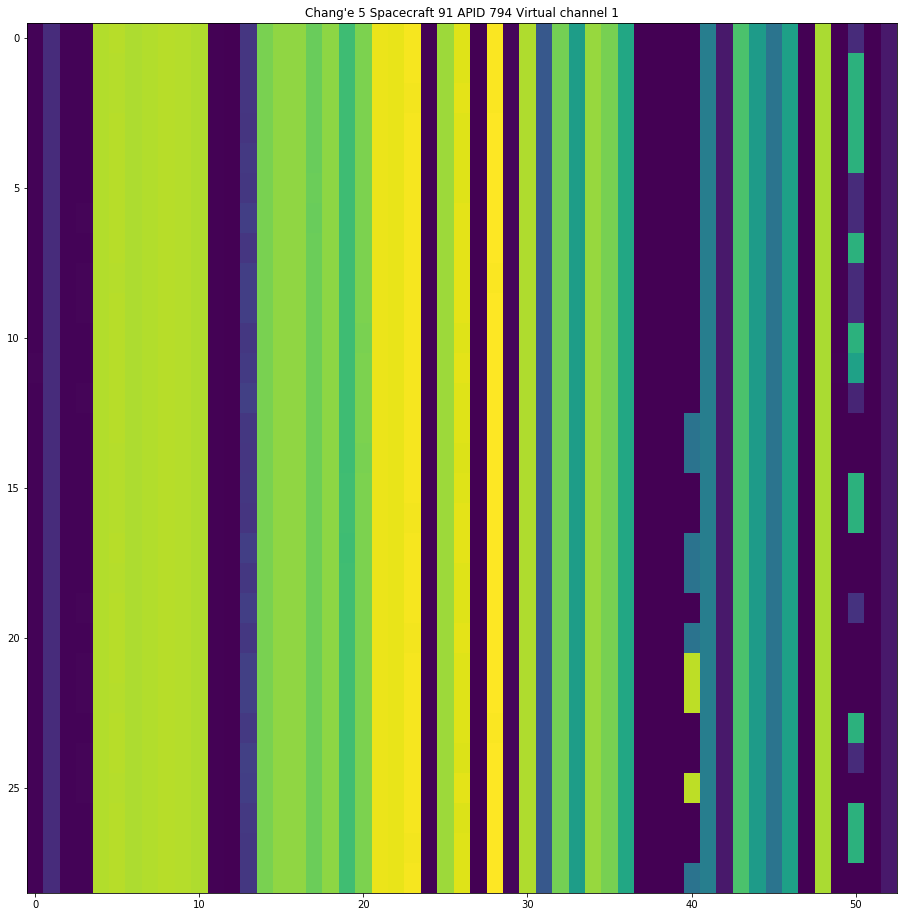

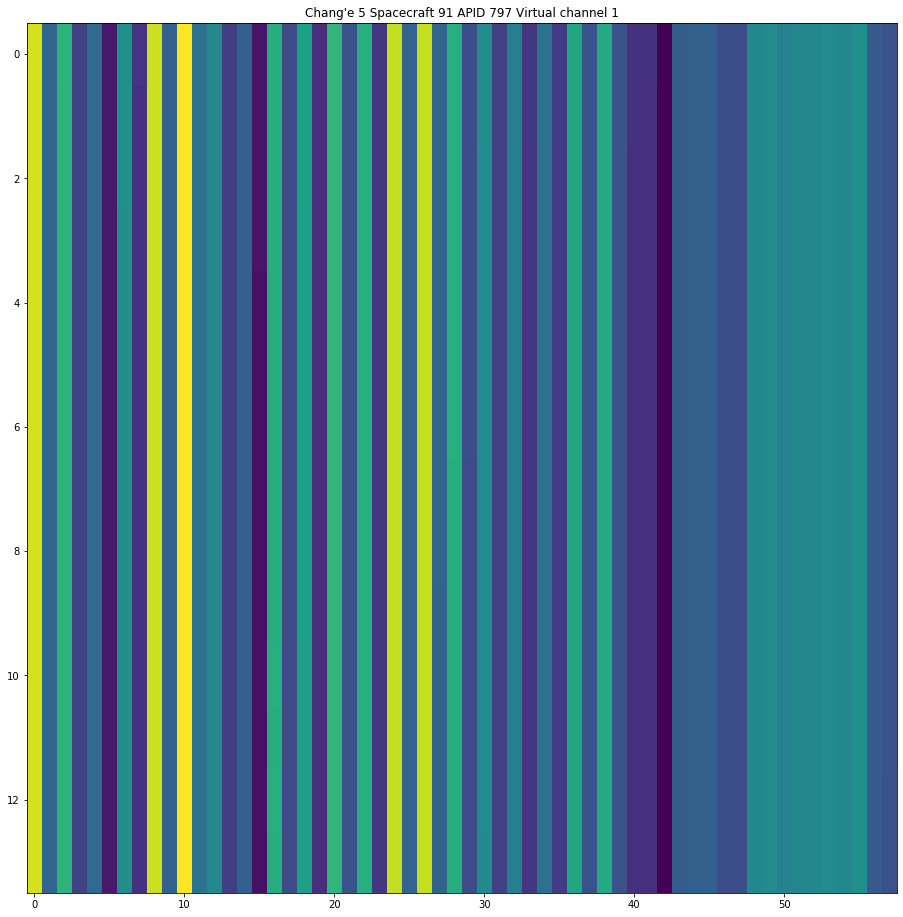

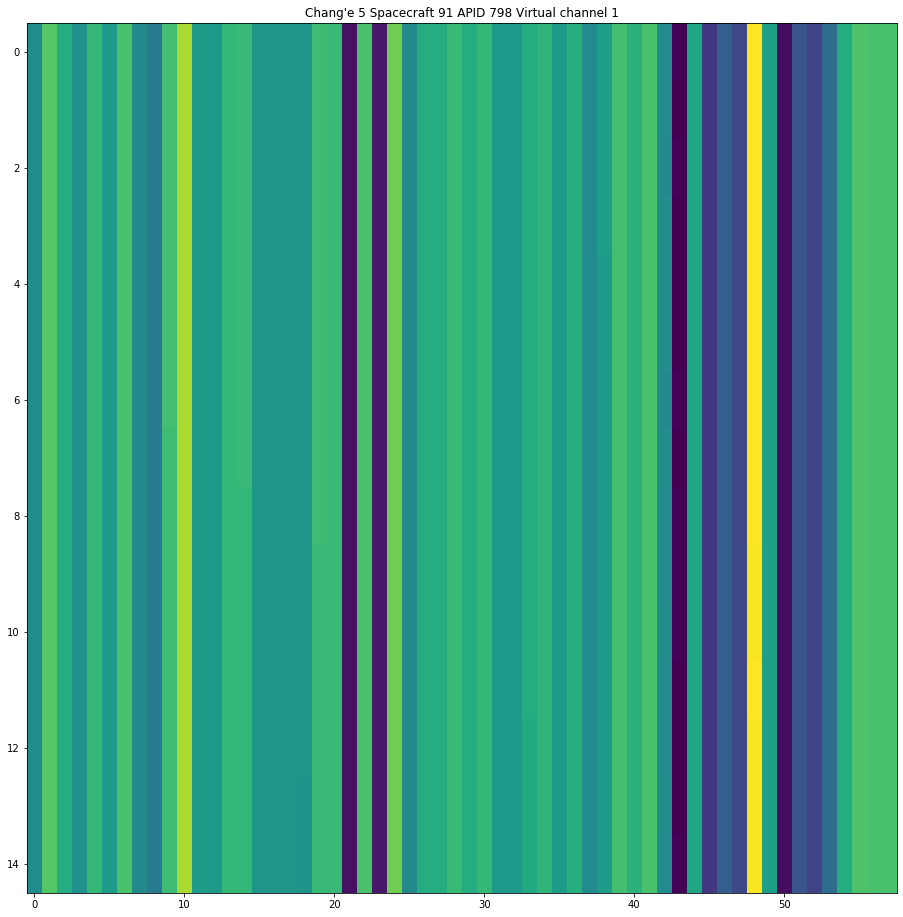

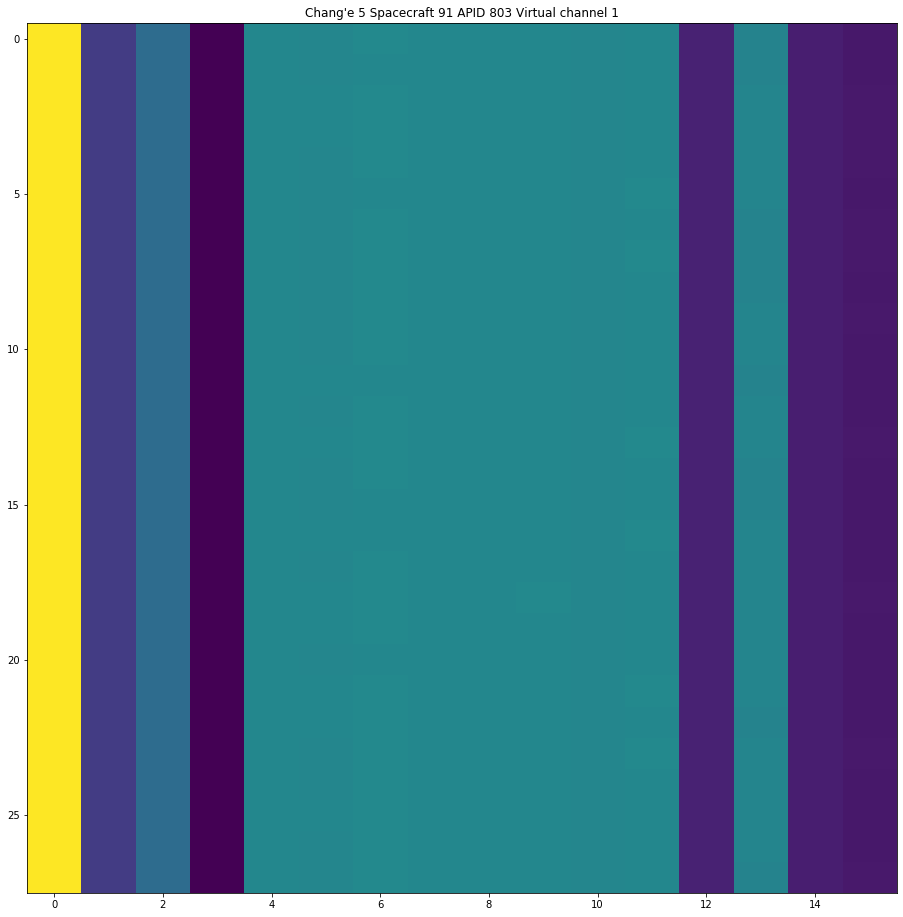

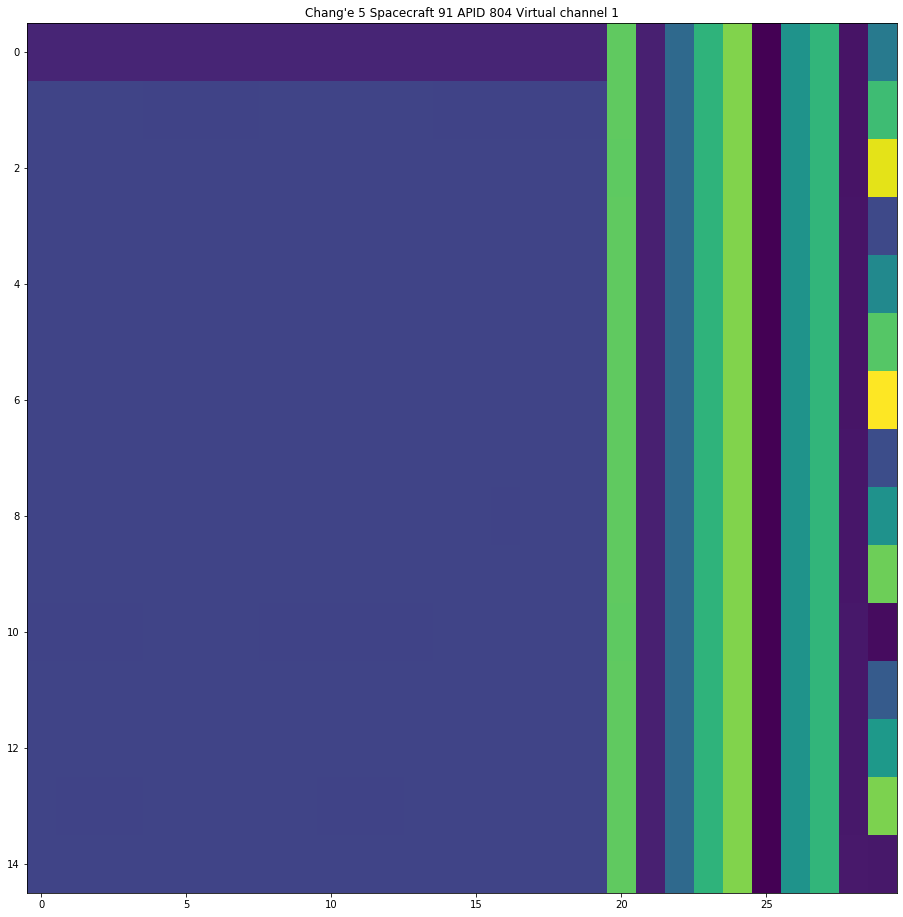

In [16]:
plot_apids(vc1_by_apid, 91, 1)